# Titanic - Desafio de Aprendizado de Máquina

<p align="center">
  <img src="https://sigmoidal.ai/wp-content/uploads/2022/06/titanic.jpg" alt="Titanic">
</p>

A tragédia do Titanic, ocorrida em abril de 1912, permanece como um dos eventos mais icônicos e trágicos da história da humanidade. Esse desastre marítimo não apenas tirou a vida de mais de 1.500 pessoas, mas também destacou questões cruciais relacionadas à engenharia naval, política de segurança marítima e desigualdade social. Neste notebook de análise, examinaremos profundamente os diversos aspectos que envolvem o naufrágio do Titanic, desde as circunstâncias que levaram ao acidente até o legado duradouro que deixou no mundo. Utilizando dados históricos, testemunhos de sobreviventes e insights de especialistas, nossa análise visa lançar luz sobre as lições aprendidas a partir deste trágico evento e como ele continua a moldar a sociedade e as indústrias até os dias atuais.

In [561]:
# Processamento de dados
import pandas as pd

# Algebra linear
import numpy as np

# Algoritmos
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Avaliações
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

# Vizualização de dados
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
warnings.simplefilter("ignore")

In [562]:
# Visualizando a base de treino
treino = pd.read_csv('train.csv')
rows, cols = treino.shape
print(f'Total de linhas: {rows}\nTotal de colunas: {cols}')
treino.head(3)

Total de linhas: 891
Total de colunas: 12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


- **Base de treino**

In [563]:
# Verificando as informações da base
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


O conjunto de treinamento possui 891 registros e 11 características + a variável alvo (Survived). 2 dos recursos são floats (reais), 5 são inteiros e 5 são objetos. Abaixo, listei os recursos com uma breve descrição:

**Dicionário**

| Variável | Definição                                | Chave                                          |
| -------- | ---------------------------------------- | ---------------------------------------------- |
| survival | Sobrevivel                               | 0 = Não, 1 = Sim                               |
| pclass   | Classe do bilhete                        | 1 = 1º Classe, 2 = 2º Classe, 3 = 3º Classe    |
| name     | Nome do passageiro                       |                                                |
| sex      | Sexo                                     |                                                |
| Age      | Idade em anos                            |                                                |
| sibsp    | Nº de irmãos/cônjuges a bordo            |                                                |
| parch    | Nº de pais/filhos a bordo                |                                                |
| ticket   | Número do bilhete                        |                                                |
| fare     | Valor da passagem                        |                                                |
| cabin    | Número de cabine                         |                                                |
| embarked | Porto de embarque                        | C = Cherbourg, Q = Queenstown, S = Southampton |

In [564]:
# analisando dados estatísticos
treino.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


Temos uma média de idade em torno de 29 anos, sendo o máximo com 80 anos. Para a época de 1912, a expectativa de vida era entre 50 a 60 anos. É assustador quando comparamos com a idade que nossos avós alcançam hoje em dia. Se olharmos para a expectativa de vida no Brasil naquela época, era de apenas 33,7 anos. Realmente impressionante! 

Além disso, podemos ver que 38% do conjunto de treinamento sobreviveram a trajédia.

O atributo Fare (passagem) está estranho, com uma média de 32,20 e uma mediana de 14,45. Os valores estão um pouco distorcidos. E temos passageiros que estão com valor da passagem zerados.

In [565]:
# Verificando porcentagem de valores ausentes
round(treino.isnull().mean()*100,2)

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

- **Base de teste**

In [566]:
teste = pd.read_csv('test.csv')

In [567]:
# Verificando as informações da base
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [568]:
# analisando dados estatísticos
teste.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


In [569]:
# Verificando porcentagem de valores ausentes
round(teste.isnull().mean()*100,2)

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.57
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.24
Cabin          78.23
Embarked        0.00
dtype: float64

## Visualização dos dados

### Classe

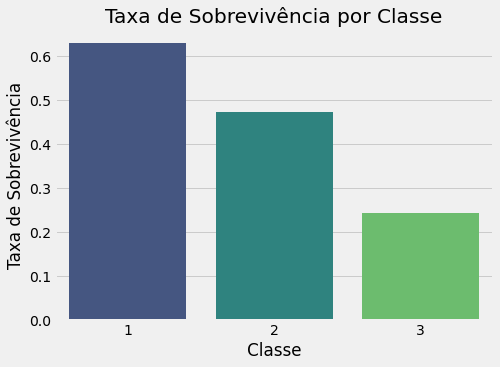

In [570]:
# Agrupano Classe do passageiro com a condição de sobrevivencia
aggregated_data = treino[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

plt.figure(figsize=(7, 5))
sns.barplot(data=aggregated_data, x='Pclass', y='Survived', palette='viridis')
plt.xlabel('Classe')
plt.ylabel('Taxa de Sobrevivência')
plt.title('Taxa de Sobrevivência por Classe')
plt.show()

Podemos observar uma taxa de sobrevivência significativamente alta, atingindo 65%, entre as pessoas da primeira classe, enquanto aqueles da terceira classe apresentam uma taxa consideravelmente menor, situando-se em 25%.

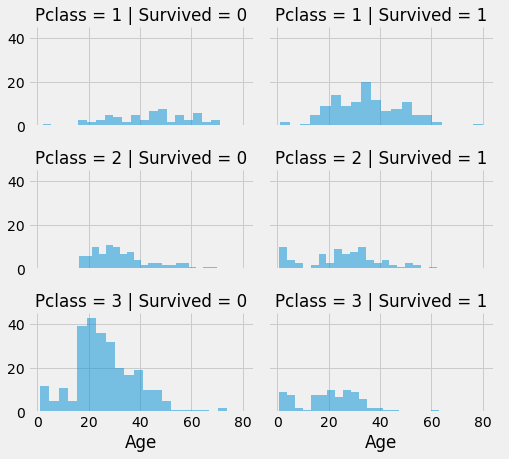

In [571]:
grid = sns.FacetGrid(treino, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

### Sexo e Idade

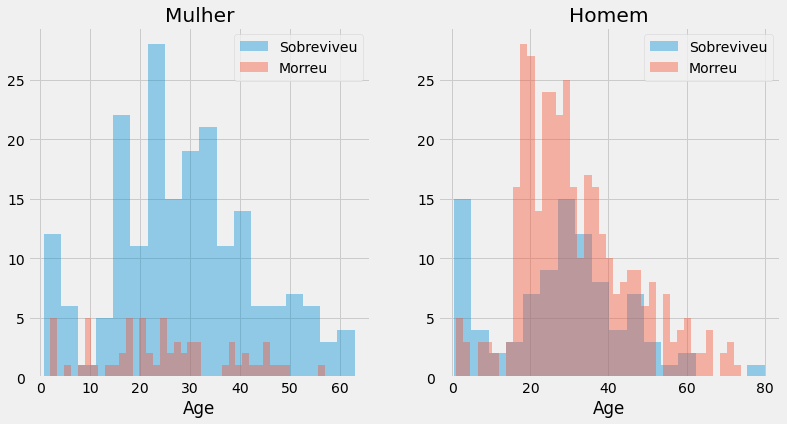

In [572]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
women = treino[treino['Sex']=='female']
men = treino[treino['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = 'Sobreviveu', ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = 'Morreu', ax = axes[0], kde =False)
ax.legend()
ax.set_title('Mulher')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = 'Sobreviveu', ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = 'Morreu', ax = axes[1], kde = False)
ax.legend()
ax.set_title('Homem')
plt.show()

É evidente que os homens apresentam uma probabilidade substancialmente elevada de sobrevivência entre as faixas etárias de 20 a 30 anos. Essa tendência é também parcialmente observada nas mulheres, embora não de forma tão marcante. Para o sexo feminino, as maiores chances de sobrevivência ocorrem entre os 14 e 40 anos.

No caso dos homens, é notável que a altra probabilidade de morte.

Devido à presença de faixas etárias específicas que impulsionam as chances de sobrevivência, e para garantir uma uniformidade nas escalas de características, a criação de grupos etários posteriormente é uma medida que pretendo adotar.

### Fare

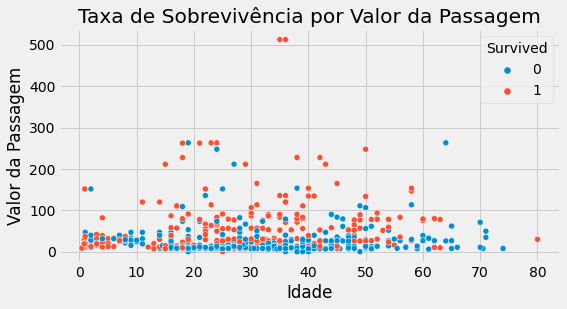

In [573]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=treino, x='Age', y='Fare', hue='Survived')
plt.xlabel('Idade')
plt.ylabel('Valor da Passagem')
plt.title('Taxa de Sobrevivência por Valor da Passagem')
plt.show()

Como já observado anteriormente, o valor da passagem está relacionado com a sobrevivência, havendo uma tendência de maior probabilidade de sobrevivência caso haja um pagamento mais elevado.

### Embarked, Classe e Gênero

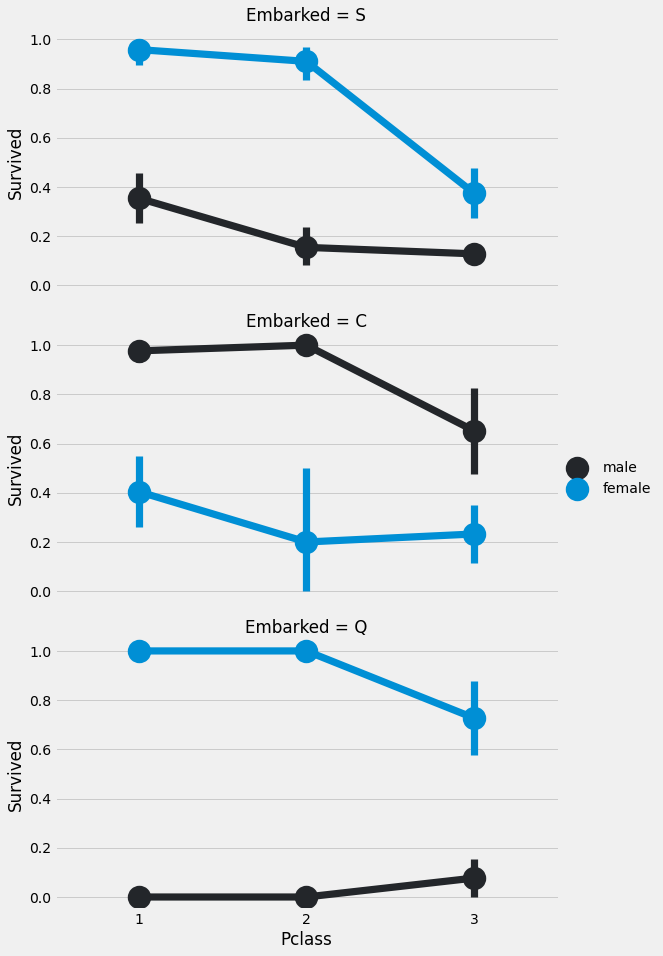

In [574]:
FacetGrid = sns.FacetGrid(treino, row='Embarked', size=4.5, aspect=1.8)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

O padrão de embarque demonstra uma correlação aparente com as taxas de sobrevivência, com a dinâmica variando de acordo com o gênero.

No caso das mulheres, aquelas que embarcaram nas portas Q e S exibiram maiores chances de sobrevivência. Contudo, essa relação se inverte ao considerarmos o porto C como ponto de embarque. No que diz respeito aos homens, observa-se que a probabilidade de sobrevivência é notavelmente alta quando o embarque ocorreu no porto C. Em contraste, a probabilidade é consideravelmente reduzida quando o embarque ocorreu nas portas Q ou S.

### SibSp e Parch

A combinação de "SibSp" (número de irmãos/cônjuges a bordo) e "Parch" (número de pais/filhos a bordo) não me parece fazer muito sentido ser analisado separadamente. Podemos criar um novo recurso, que representará essa soma mais um, ou seja, o tamanho da familía.

In [575]:
data = [treino, teste]
for dataset in data:
    dataset['family_size'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset.loc[dataset['family_size'] > 1, 'Is_Alone'] = 0
    dataset.loc[dataset['family_size'] == 1, 'Is_Alone'] = 1
    dataset['Is_Alone'] = dataset['Is_Alone'].astype(int)
    dataset.drop(['SibSp', 'Parch'], axis=1, inplace=True)
treino['Is_Alone'].value_counts()

1    537
0    354
Name: Is_Alone, dtype: int64

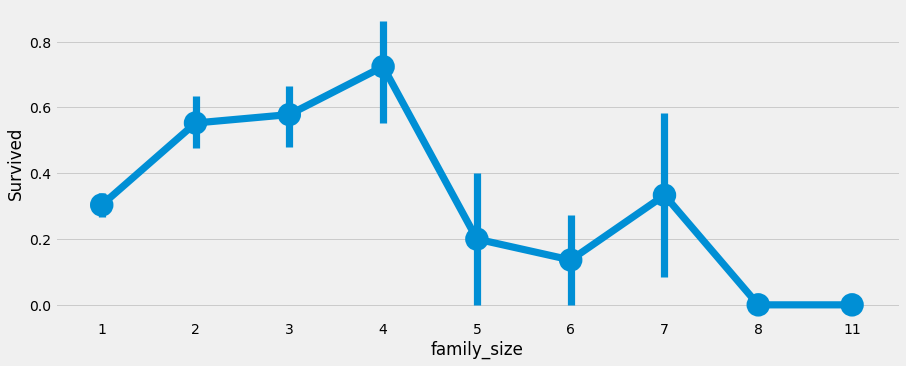

In [576]:
axes = sns.factorplot('family_size','Survived', data=treino, aspect = 2.5)

Aqui podemos ver que você tinha uma alta probabilidade de sobrevivência com o tamanho da família de 2 a 4.

### Idade e Sobrevivência

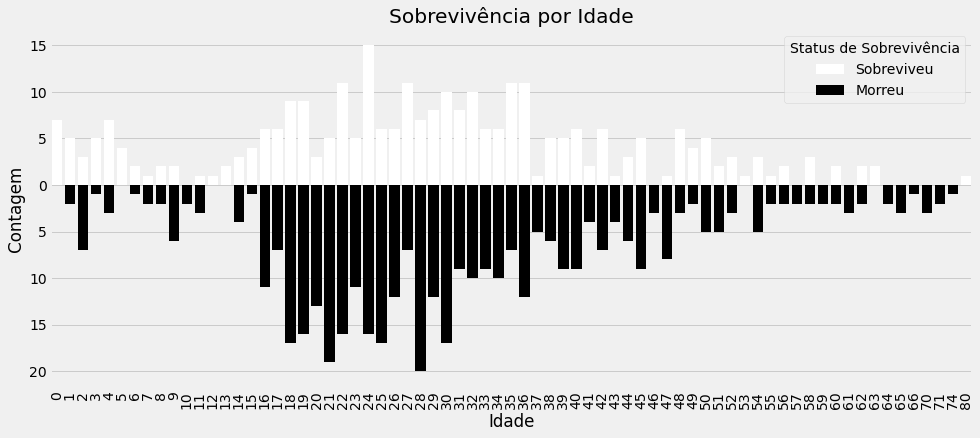

In [577]:
treino2 = treino.copy()
treino2 = treino2[treino2['Age'].notnull()]
treino2['Age'] = treino2.Age.astype(int)
survival_counts = treino2.groupby(['Age', 'Survived']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.barplot(x=survival_counts.index, y=survival_counts[1], color='white', label='Sobreviveu')
sns.barplot(x=survival_counts.index, y=-survival_counts[0], color='black', label='Morreu')

plt.xticks(rotation=90)
plt.tight_layout()
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.title('Sobrevivência por Idade')

plt.gca().set_yticklabels([int(abs(tick)) for tick in plt.gca().get_yticks()])

plt.legend(title="Status de Sobrevivência", loc="upper right")
plt.show()

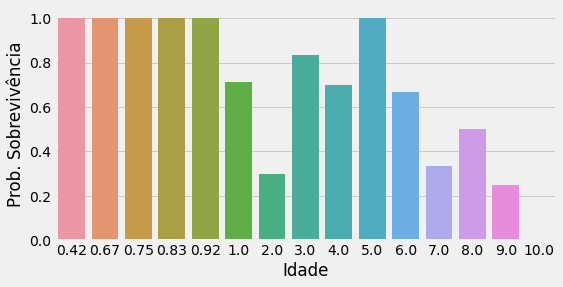

In [578]:
plt.figure(figsize=(8, 4))
aggregated_data = treino[treino.Age <=10].groupby(['Age'], as_index=False).mean()
sns.barplot(data=aggregated_data, x=aggregated_data.Age, y='Survived')
plt.xlabel('Idade')
plt.ylabel('Prob. Sobrevivência')
plt.show()

Podemos notar que crianças com meses de vida tem uma taxa de 100% de sobrevivência.

### Nomes e Títulos

In [579]:
df_treino = treino.copy()

df_treino['Title'] = df_treino.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip().lower())


As nomeclaturas são definidas como:

- `mr` -> Senhor (usado para homens casados)
- `mrs` -> Senhora  (usado para mulheres casadas)
- `miss` -> Srta. / Senhorita
- `master` -> Senhor (usado para um jovem)
- `don` -> Dom
- `rev` -> Reverendo
- `dr` -> Doutor
- `mme` -> Madame (equivalente a Senhora em francês)
- `ms` -> Senhorita / Senhora (usado como forma neutra de tratamento)
- `major` -> Major (grau militar)
- `lady` -> Dama / Senhora
- `sir` -> Senhor / Cavaleiro
- `mlle` -> Mademoiselle (equivalente a Senhorita em francês)
- `col` -> Coronel (grau militar)
- `capt` -> Capitão (grau militar)
- `the countess` -> Condessa
- `jonkheer` -> Título nobiliárquico da Baixa Saxônia, Holanda e Bélgica (equivalente a nobre).

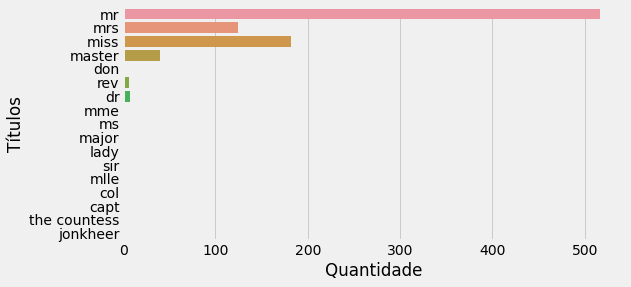

In [580]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_treino, y='Title')
plt.xlabel('Quantidade')
plt.ylabel('Títulos')
plt.show()

Podemos observar uma alta concentração de 4 títulos: "Mr.", "Mrs.", "Miss" e "Master". Vamos analisar a taxa de sobrevivência associada a esses títulos.

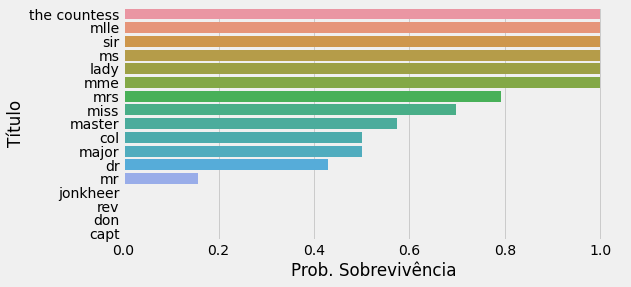

In [581]:
plt.figure(figsize=(8, 4))
aggregated_data = df_treino.groupby(['Title']).mean().sort_values(by='Survived',ascending=False)
sns.barplot(data=aggregated_data, y=aggregated_data.index, x='Survived')
plt.ylabel('Título')
plt.xlabel('Prob. Sobrevivência')
plt.show()

Interessante. Devemos ter cuidado para que a exceção não se torne regra. Embora possamos observar que Coronel possui uma taxa de sobrevivência de 100%, é importante lembrar que, como vimos anteriormente, a contagem nesse caso é quase insignificante. Portanto, não podemos generalizar essa situação para todos os casos.

# Processamento dos Dados

Vamos proceder à criação de uma cópia do nosso conjunto de dados original para procedimentos de limpeza de dados.

In [582]:
treino_filtrado = treino.copy()
teste_filtrado = teste.copy()

Primeiro, retirarei 'PassengerId' do conjunto de treino, porque não contribui para a probabilidade de sobrevivência de uma pessoa. Não vou retirá-lo do conjunto de teste, pois é necessário lá para o envio no Kaggle.

In [583]:
treino_filtrado = treino_filtrado.drop(['PassengerId'], axis=1)

# Crianção da lista de dataset para futuras limpezar mais rapidas
data = [treino_filtrado, teste_filtrado]

### Name

Utilizaremos o recurso `Name` para extrair os títulos dos nomes, como realizado anteriormente. No entanto, vamos considerar os casos com contagem insignificante como ocorrências excepcionais.

In [584]:
# Crie uma instância do LabelEncoder
label_encoder = LabelEncoder()
titulo = {"mr": 1, "miss": 2, "mrs": 3, "master": 4, "excep": 5}

for dataset in data:
    # Extraindo os titulos dos nomes
    dataset['Title'] = dataset.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip().lower())
    
    # Substituindo os títulos por um título mais comum ou como excep
    dataset['Title'] = dataset['Title'].replace('mlle', 'miss')
    dataset['Title'] = dataset['Title'].replace('ms', 'miss')
    dataset['Title'] = dataset['Title'].replace('mme', 'mrs')
    dataset['Title'] = dataset['Title'].replace(['lady', 'the countess', 'countess','capt', 'col','don', 'dr', 'major', 'rev', 'sir', 'jonkheer', 'dona'], 'excep')
    
    # Usar o LabelEncoder para converter títulos em números
    dataset['Title'] = label_encoder.fit_transform(dataset['Title'])
    # dataset['Title'] = dataset['Title'].map(titulo)
    
    # Descartando o recurso Name
    dataset.drop(['Name'], axis=1, inplace=True)

In [585]:
# treino_filtrado = pd.get_dummies(treino_filtrado, columns=['Titulo'])
# teste_filtrado = pd.get_dummies(teste_filtrado, columns=['Titulo'])  

# data = [treino_filtrado, teste_filtrado]

## Dados Ausentes

### Idade

Vamos prosseguir com o cálculo da média das idades para preencher os dados ausentes. Inicialmente, poderíamos considerar o preenchimento com a média das idades. No entanto, a ideia de atribuir a mesma idade a 20% do nosso conjunto de dados pode não ser realista. Uma outra obordagem poderia ser explorar a aplicação de outro modelo para estimar a idade com base em recursos específicos.

Porém para essa análise, vamos criar uma matriz que contenha números aleatórios. Esses números serão calculados levando em consideração o valor médio da idade em relação ao desvio padrão.

In [586]:
for dataset in data:
    media = dataset["Age"].mean()
    std = dataset["Age"].std()
    is_null = dataset["Age"].isnull().sum()

    # calcula números aleatórios entre a média, std e total de ausentes
    rand_age = np.random.randint(media - std, media + std, size = is_null)

    # preenche os valores NaN na coluna Age com valores aleatórios gerados
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)

In [587]:
# for cat, inter in enumerate(pd.qcut(treino_filtrado.Age, 5).cat.categories):
#     print(f'Categoria: {cat}\t|\tIntervalo: {inter}')

In [588]:
# for dataset in data:
#     dataset['Age'] = pd.qcut(dataset.Age, 5, labels=False)

### Embarked

No caso do atributo `Embarked`, em que dispomos de informações limitadas para determinar o local de embarque do passageiro, a melhor abordagem é preencher os dados faltantes com a moda, ou seja, preenchendo com o mais comum.

In [589]:
# Preenchendo Embarque com a moda
treino_filtrado.loc[treino_filtrado.Embarked.isnull(), 'Embarked'] = treino_filtrado.Embarked.mode()[0]

### Fare

Para o atributo `Fare`, só temos uma único registro ausente

In [590]:
teste_filtrado[teste_filtrado['Fare'].isnull()]

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size,Is_Alone,Title
152,1044,3,male,60,3701,NaN,NaN,S,1,1,3


Para encontrar informações semelhantes, podemos realizar uma consulta (query) considerando diversas características relevantes, tais como a classe da pessoa, o local de embarque e se ela estava acompanhada. Através desse processo, obtemos a média das pessoas com características semelhantes, o que nos permite preencher o dado faltante de forma mais precisa e confiável.

In [591]:
filtro = "Pclass == 3 and Embarked == 'S' and family_size == 1 and Sex == 'male'"
teste_filtrado.query(filtro)['Fare'].mean()

9.096774666666665

In [592]:
# Preenchendo o valor da passagem com semelhança de passageiros
teste_filtrado.loc[teste_filtrado.Fare.isnull(), 'Fare'] = teste_filtrado.query(filtro)['Fare'].mean()

In [593]:
# for cat, inter in enumerate(pd.qcut(teste_filtrado.Fare, 5).cat.categories):
#     print(f'Categoria: {cat}\t|\tIntervalo: {inter}')

In [594]:
# for dataset in data:
#     dataset['Fare'] = pd.qcut(dataset.Fare, 5, labels=False)

Alem disso, temos aluns valores estranho, pessoas viajando pagando 0 dinheiros

In [595]:
treino[treino.Fare == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size,Is_Alone
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,LINE,0.0,NaN,S,1,1
263,264,0,1,"Harrison, Mr. William",male,40.0,112059,0.0,B94,S,1,1
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,LINE,0.0,NaN,S,1,1
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,239853,0.0,NaN,S,1,1
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,LINE,0.0,NaN,S,1,1
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,239853,0.0,NaN,S,1,1
466,467,0,2,"Campbell, Mr. William",male,NaN,239853,0.0,NaN,S,1,1
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,239854,0.0,NaN,S,1,1
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,LINE,0.0,NaN,S,1,1
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,112052,0.0,NaN,S,1,1


In [596]:
# # Calcular a média dos valores não-zero agrupados por Pclass e Sex
# fare_mean_by_class_sex = treino_filtrado[treino_filtrado.Fare > 0].groupby(['Pclass', 'Sex','Embarked'])['Fare'].mean()

# # Função para substituir os valores zero pelo valor médio correspondente
# def replace_zero_fare(row):
#     if row['Fare'] == 0:
#         return fare_mean_by_class_sex[row['Pclass'], row['Sex'], row['Embarked']]
#     return row['Fare']

# # Aplicar a função para substituir os valores zero na coluna Fare
# treino_filtrado['Fare'] = treino_filtrado.apply(replace_zero_fare, axis=1)
# teste_filtrado['Fare'] = teste_filtrado.apply(replace_zero_fare, axis=1)

In [597]:
# for dataset in data:
#     dataset['Age_Class']= dataset['Age']* dataset['Pclass']

### Cabines

As Cabinas possuem aproximadamente 77% de seus dados ausentes, então poderíamos cogitar em eliminar essa coluna, porém, pesquisando sobre as cabines do RSM Titanic, encontrei a seguinte imagem:

<p align="center">
    <img src="image/setor_cabines.png" alt="Protótipo de imagem das cabinas frontal do RSM Titanic" width="300">
    <img src="image/ward_map_class.png" alt="Protótipo de imagem das cabinas leterais do RSM Titanic" width="400">
</p>

A maior parte das instalações e acomodações da Primeira Classe no Titanic situava-se nos conveses superiores, proporcionando aos passageiros um ambiente com menores vibrações e ruídos dos motores. O Convés `A`, assim como a maioria dos conveses `B` e `C`, era dedicado ao espaço de recreação e alojamento da Primeira Classe. Além disso, as acomodações da Primeira Classe estendiam-se por todos os níveis até o Convés `F`, garantindo aos passageiros desta classe um espaço superior em relação às outras classes a bordo.

<p align="center">
    <img src="image/titanic_class.jpg" width="1000">
</p>

A partir das localizações conhecidas, podemos tentar analisar o trágico acidente que ocorreu à noite, quando grande parte dos passageiros estava em seus aposentos. Inicialmente, vamos buscar obter informações disponíveis, considerando que temos muitos dados ausentes. Podemos usar essa informação parcial como um adicional para a nossa análise. Se temos informações sobre a cabine, ótimo, podemos incluí-la. Caso não tenhamos essa informação, prosseguiremos normalmente, como se ela não estivesse disponível.

Em etapas futuras, podemos tentar aplicar um modelo para prever em qual cabine o passageiro estaria, levando em consideração o valor da passagem e sua classe, buscando uma abordagem mais completa e precisa na análise.

In [598]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}

##### Substituindo os valores ausentes por Zero

Para uma ultilização simples, podemos substituir os valores ausentes por zero.

In [599]:
# # Extraindo as letras do conves e transformando em números
# for dataset in data:
#     dataset['Deck'] = dataset['Cabin'].str.extract(r'([a-gA-G]+)')
#     dataset['Deck'] = dataset['Deck'].map(deck)
#     dataset['Deck'] = dataset['Deck'].fillna(0)
#     dataset['Deck'] = dataset['Deck'].astype(int)
#     dataset.drop(['Cabin'], axis=1, inplace=True)

#### Aplicando metodo de aprendizado semi-supervisionado Co-training

O co-training é uma técnica de aprendizado de máquina semi-supervisionado que envolve treinar modelos usando múltiplas fontes de dados, onde cada fonte fornece uma visão diferente do problema. Essa abordagem é útil quando você tem uma grande quantidade de dados não rotulados e uma pequena quantidade de dados rotulados disponíveis.

In [600]:
# Obtendo a copia do dataset que iremos treinar
co_training = treino_filtrado.copy()

# Extraindo somente o convés das cabines
co_training['Cabin'] = co_training['Cabin'].str.extract(r'([a-gA-G]+)')

# Convertendo categorio em numerico
co_training = pd.get_dummies(co_training, columns=['Sex'])   


# Dividindo os dados em um conjunto rotulado e outro não rotulado
labeled_data = co_training[co_training['Cabin'].notnull()]
unlabeled_data = co_training[co_training['Cabin'].isnull()]

# Selecionando as colunas relevantes para treinamento
feature_columns = ['Pclass', 'Sex_male', 'Sex_female','Age', 'Fare']
X_labeled = labeled_data[feature_columns]
y_labeled = labeled_data['Cabin']
X_unlabeled = unlabeled_data[feature_columns]

# Dividindo o conjunto rotulado em treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Criando dois modelos de árvore de decisão com diferentes conjuntos de características
model_1 = DecisionTreeClassifier(random_state=42)
model_2 = DecisionTreeClassifier(random_state=42)

# Treinando os modelos nos dados rotulados
model_1.fit(X_train, y_train)
model_2.fit(X_train[['Pclass', 'Sex_male', 'Sex_female']], y_train)  # Usamos duas características específicas como exemplo

# Classificando os dados não rotulados e selecionando os mais confiantes
unlabeled_predictions_1 = model_1.predict(X_unlabeled)
unlabeled_predictions_2 = model_2.predict(X_unlabeled[['Pclass', 'Sex_male', 'Sex_female']])

confident_indices_1 = np.where(unlabeled_predictions_1 == unlabeled_predictions_2)[0]
confident_unlabeled_data = X_unlabeled.iloc[confident_indices_1]

# Adicionando os exemplos mais confiantes ao conjunto rotulado e treinando novamente os modelos
X_train = pd.concat([X_train, confident_unlabeled_data])
y_train = pd.concat([y_train, pd.Series(unlabeled_predictions_1[confident_indices_1])])

model_1.fit(X_train, y_train)
model_2.fit(X_train[['Pclass', 'Sex_male', 'Sex_female']], y_train)  # Usamos as mesmas características selecionadas anteriormente


deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}

# Agora podemos usar os modelos treinados para fazer previsões em novos dados
treino_df = pd.get_dummies(treino_filtrado, columns=['Sex'])  
teste_df = pd.get_dummies(teste_filtrado, columns=['Sex'])  
data = [treino_df, teste_df]
for dataset in data:
    # dataset['Sex'] = dataset.Sex.apply(lambda x: 0 if x == 'male' else 1).astype(int)
    dataset['Deck'] = dataset['Cabin'].str.extract(r'([a-gA-G]+)')
    predictions_1 = model_1.predict(dataset[feature_columns])
    dataset.loc[dataset['Deck'].isnull(), 'Deck'] = predictions_1[dataset['Deck'].isnull()]
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset.drop(['Cabin'], axis=1, inplace=True)

treino_filtrado = treino_df.copy()
teste_filtrado = teste_df.copy()

### Convertendo Recursos 

#### Gênero

Agora podemos converter as strings em valores numéricos, pois a maioria dos algoritmos de modelo necessitam dessa conversão.

Vamos começar convertendo a coluna `Sex` em númerico, e como não temos um sentido ordinal, podemos aplicar o one-hot-encoding que significa em transformar os valores em variáveis(colunas) e binárias.

In [ ]:
treino_filtrado = pd.get_dummies(treino_filtrado, columns=['Sex'])   
teste_filtrado = pd.get_dummies(teste_filtrado, columns=['Sex'])   

In [ ]:
# treino_filtrado = pd.get_dummies(treino_filtrado, columns=['Sex'])
# teste_filtrado = pd.get_dummies(teste_filtrado, columns=['Sex'])   
# # for dataset in data:
# #     dataset['Sex'] = dataset.Sex.apply(lambda x: 0 if x == 'male' else 1).astype(int)

#### Embarked

Seguindo a mesma logica do recurso gênero

In [602]:
treino_filtrado = pd.get_dummies(treino_filtrado, columns=['Embarked'])   
teste_filtrado = pd.get_dummies(teste_filtrado, columns=['Embarked'])   

In [558]:
# data = [treino_filtrado, teste_filtrado]
# embarked = {'S': 1, 'C': 2, 'Q': 3}
# for dataset in data:
#     dataset.Embarked = dataset.Embarked.map(embarked).astype(int)

#### Ticket

O recurso "Ticket" possui 681 tickets exclusivos, porém não apresenta grande relevância para nós. Portanto, optaremos por descartá-lo.

In [603]:
treino_filtrado.drop(['Ticket'], axis=1, inplace = True)
teste_filtrado.drop(['Ticket'], axis=1, inplace = True)

### Avaliação

In [358]:
from collections import defaultdict

tabela_resultados = defaultdict(list)

models = {
       'XGBooster': XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, min_child_weight=1),
        'Regressão Logistica': LogisticRegression(max_iter=800, C=1.0, penalty='l1', solver='liblinear'),
        'Árvore de decisão': DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=10),
        'Perceptron': Perceptron(alpha=0.01, eta0=0.001, max_iter=1000, penalty='elasticnet', tol=0.001),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=1),
        'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
}    
def validacao(X, y):
    kfold = StratifiedKFold(n_splits=5, shuffle=False)
         
    for model_name, model in models.items():
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        media_acuracia = cv_results.mean()
        
        if model_name not in tabela_resultados:
            tabela_resultados[model_name] = []
        tabela_resultados[model_name].append(media_acuracia)
        
    return tabela_resultados

In [604]:
# Código para chamar a função e exibir a tabela:
X = treino_filtrado.drop(['Survived'], axis=1)
y = treino_filtrado.Survived

# Chamada da função
tabela_resultados = validacao(X, y)

# Mostrar a tabela atualizada
results = pd.DataFrame(tabela_resultados)
results_transposed = results.transpose()  # Troca linhas por colunas

# Renomear as colunas para "1 tentativa", "2 tentativa", etc.
results_transposed.columns = [f"{i+1} Tentativa" for i in range(len(results_transposed.columns))]

results_transposed

,1 Tentativa,2 Tentativa,3 Tentativa,4 Tentativa,5 Tentativa
XGBooster,0.823859,0.841743,0.826062,0.829421,0.832779
Regressão Logistica,0.784540,0.795750,0.800239,0.784527,0.783397
Árvore de decisão,0.805913,0.812598,0.799127,0.784558,0.808110
Perceptron,0.642000,0.684728,0.716138,0.635196,0.675720
Random Forest,0.835026,0.824914,0.829402,0.827192,0.832773
GradientBoostingClassifier,0.819327,0.808104,0.803616,0.819321,0.819321


In [ ]:
X.head()

,Pclass,Age,Fare,Titulo,Is_Alone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,7.2500,1,0,0,1,0,0,1
1,1,38.0,71.2833,3,0,1,0,1,0,0
2,3,26.0,7.9250,2,1,1,0,0,0,1
3,1,35.0,53.1000,3,0,1,0,0,0,1
4,3,35.0,8.0500,1,1,0,1,0,0,1


## Salvando arquivo para submissão no Kaggle 

In [ ]:
X_test = teste_filtrado.drop(['PassengerId'],axis=1)
X_test = X_test[X.columns]

for model_name, model in models.items():
    model = model.fit(X,y)
    y_pred = model.predict(X_test)
    df = pd.DataFrame({'PassengerId': teste_filtrado.PassengerId,'Survived': y_pred})
    if model_name == 'Random Forest':
        randomForest = df.copy()
    df.to_csv(f'predictions/{model_name}.csv', index=False)